In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers import Dense, Dropout,Input,Flatten
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras

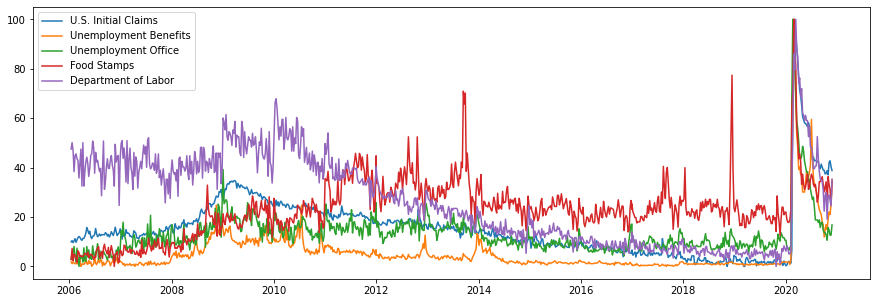

In [119]:
dfs=[]
df=pd.read_excel("./FullDataset.xlsx")
df=df.drop(columns=["Jobs","Indeed","Cover Letter","Linkedin","Social Security Office Locations",
                    "Monster","Social Security Gov","Hotjobs","Job Search","Social Security","Job Search Engines",
                    "Resume"])

df['claims'] =(np.log2(df['claims']))
df=df.rename(columns={"claims":"U.S. Initial Claims"})
# df=df.drop(columns=["date"])
train_dates = pd.to_datetime(df['date'])
cols = list(df)[1:]
df_for_training = df[cols].astype(float)
scaler = MinMaxScaler((0,100))
scaler = scaler.fit(df_for_training)
df = scaler.transform(df_for_training)

dfs.append(df)
df=pd.read_excel("./DatasetSummed.xlsx")
df['Jobs'] = np.log2(df['Jobs'])
df['welfare'] = np.log2(df['welfare'])
df['claims'] = np.log2(np.log2(df['claims']))
# df=df.drop(columns=["welfare"])
tmp=df
dfs.append(df)
df=df.drop(columns=["Jobs"])
dfs.append(df)
# df=df[:-50]
df.head()

plt.figure(figsize=(15, 5))
plt.plot(pd.DataFrame(dfs[0],index=dfs[1]["date"][:-4]))
plt.legend(cols,loc='upper left')
index=dfs[1].index[:-4]

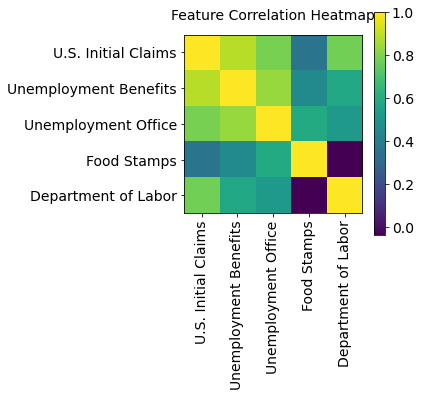

In [122]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()
show_heatmap(pd.DataFrame(dfs[0],columns=cols,index=dfs[1]["date"][:-4]))


In [ ]:

df[-int(len(df)*.1):].tail()




#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
from random import choices,sample
choices(range(1,10),k=2)


[1, 4]

In [ ]:
for df in dfs:
  if len(df.columns)!=4:
    continue
  df=df[:-52-51]

  #Separate dates for future plotting
  train_dates = pd.to_datetime(df['date'])
  cols = list(df)[1:]
  df_for_training = df[cols].astype(float)
  scaler = StandardScaler()
  scaler = scaler.fit(df_for_training)
  df_for_training_scaled = scaler.transform(df_for_training)

  
  futures=[1,4,4*3,4*6,4*12]
  for future in futures:
    #As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
    #In this example, the n_features is 2. We will make timesteps = 3. 
    #With this, the resultant n_samples is 5 (as the input data has 9 rows).
    trainX = []
    trainY = []

    n_future = future   # Number of days we want to predict into the future
    n_past = 12    # Number of past days we want to use to predict the future

    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))


    # define Autoencoder model
    val_mape=100
    c=0
    modelfinal=None
    while c<2:
      model = Sequential()
      # model.add(Input(shape=(trainX.shape[1], trainX.shape[2])))
      # model.add(Conv1D(32, (3), input_shape=(trainX.shape[1], trainX.shape[2])))
      # model.add(Activation('relu'))
      # # model.add(MaxPooling1D())

      # model.add(Conv1D(32, (3)))
      # model.add(Activation('relu'))


      # model.add(Conv1D(64, (3)))
      # model.add(Activation('relu'))

      # model.add(Flatten())

      model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
      model.add(LSTM(32, activation='relu', return_sequences=False))
      model.add(Dropout(0.2))
      model.add(Flatten())
      # model.add(Dense(128,activation="relu"))
      model.add(Dense(64))
      model.add(Dense(trainY.shape[1]))
      model.compile(optimizer='adam', loss='mse', metrics=["mape"])
      callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=False)
      history = model.fit(trainX, trainY, epochs=200, batch_size=64, validation_split=0.1, verbose=0,callbacks=[callback])
      val=history.history["val_mape"][-1]
      if val<val_mape:
        val_mape=val
      modelfinal=model
      c+=1
    # fit model

    model=modelfinal

    d=""
    if len(df.columns)==4:
      d="DatasetSummed"
    elif len(df.columns)>4:
      d="FullDataset"
    else:
      d="ClaimsOnly"
    model.save("./models/LSTM/LSTM_"+str(d)+"_past12_future"+str(future)+".h")

trainX shape == (672, 12, 3).
trainY shape == (672, 1).
INFO:tensorflow:Assets written to: ./models/LSTM/LSTM_DatasetSummed_past12_future1.h/assets
trainX shape == (669, 12, 3).
trainY shape == (669, 1).
INFO:tensorflow:Assets written to: ./models/LSTM/LSTM_DatasetSummed_past12_future4.h/assets
trainX shape == (661, 12, 3).
trainY shape == (661, 1).
INFO:tensorflow:Assets written to: ./models/LSTM/LSTM_DatasetSummed_past12_future12.h/assets
trainX shape == (649, 12, 3).
trainY shape == (649, 1).
INFO:tensorflow:Assets written to: ./models/LSTM/LSTM_DatasetSummed_past12_future24.h/assets
trainX shape == (625, 12, 3).
trainY shape == (625, 1).
INFO:tensorflow:Assets written to: ./models/LSTM/LSTM_DatasetSummed_past12_future48.h/assets


In [ ]:
futures=[1,4,4*3,4*6,4*12]
data=["DatasetSummed","ClaimsOnly"]
names=["LSTM"]#["Conv2DMod","LSTM"]
for future in futures:
  for d in data:
    for name in names:
      if name=="LSTM":
        model = load_model("./models/"+str(name)+"/"+str(name)+"_"+str(d)+"_past12_future"+str(future)+".h")
      else:
        model = load_model("./models/"+str(name)+"/"+str(name)+str(d)+"_past12_future"+str(future)+".h")
      # plt.plot(history.history['loss'], label='Training loss')
      # plt.plot(history.history['val_loss'], label='Validation loss')
      # plt.legend()
      if d=="FullDataset":
        df=dfs[0]
      elif d=="DatasetSummed":
        df=dfs[1]
      else:
        
        df=dfs[2]
      df=df[:-52]
      #Separate dates for future plotting
      train_dates = pd.to_datetime(df['date'])
      cols = list(df)[1:]
      df_for_training = df[cols].astype(float)
      scaler = StandardScaler()
      scaler = scaler.fit(df_for_training)
      df_for_training_scaled = scaler.transform(df_for_training)

      trainX = []
      trainY = []

      n_future = future   # Number of days we want to predict into the future
      n_past = 12    # Number of past days we want to use to predict the future

      for i in range(n_past, len(df_for_training_scaled) - n_future +1):
          trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
          trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])
      
      trainX, trainY = np.array(trainX), np.array(trainY)
      #Forecasting...
      #Start with the last day in training date and predict future...
      n_future=51  #Redefining n_future to extend prediction dates beyond original n_future dates...
      forecast_period_dates = df["date"].tolist()[-n_future:]
      # from keras.models import load_model
      try:
        forecast = model.predict(trainX[-n_future:]) #forecast 
      except:
        print(model.input)
        print(trainX.shape)
        break
      #Perform inverse transformation to rescale back to original range
      #Since we used 5 variables for transform, the inverse expects same dimensions
      #Therefore, let us copy our values 5 times and discard them after inverse transform
      forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
      y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


      # Convert timestamp to date
      forecast_dates = []
      for time_i in forecast_period_dates:
          forecast_dates.append(time_i.date())
          
      df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'claims':y_pred_future})
      df_forecast['date']=pd.to_datetime(df_forecast['date'])
       
      original = df[['date', 'claims']]
      original['date']=pd.to_datetime(original['date'])
      original = original.loc[original['date'] >= '2019-01-06']

      def mape(actual, pred): 
        actual, pred = np.array(actual), np.array(pred)
        return np.mean(np.abs((actual - pred) / actual)) * 100
      def rmse(predictions, targets):
        return np.sqrt(((np.array(predictions)  - np.array(targets)) ** 2).mean())

      m=mape(original["claims"].tolist(),df_forecast["claims"].tolist())
      mse=rmse(original["claims"].tolist(),df_forecast["claims"].tolist())

      sns_plot=sns.lineplot(original['date'], original['claims']).set_title(str(name)+str(d)+"_past12_future"+str(future)+"_MAPE: "+str(m)+"_MSE: "+str(mse))
      sns_plot=sns.lineplot(df_forecast['date'], df_forecast['claims'])
      sns_plot.figure.savefig("./"+str(name)+str(d)+"_past12_future"+str(future)+".png")
      sns_plot.figure.clf()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


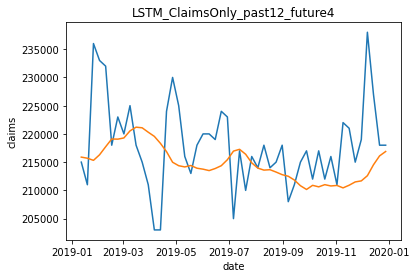

In [36]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()
df=dfs[2][:-52]
df[-int(len(df)*.1):].tail()

#Separate dates for future plotting
train_dates = pd.to_datetime(df['date'])
cols = list(df)[1:]
df_for_training = df[cols].astype(float)
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 12    # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
#Forecasting...
#Start with the last day in training date and predict future...
n_future=51  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = df["date"].tolist()[-n_future:]
# from keras.models import load_model
model = load_model('./models/LSTM/LSTM_ClaimsOnly_past12_future4.h')
forecast = model.predict(trainX[-n_future:]) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'claims':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = df[['date', 'claims']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2019-01-06']

sns.lineplot(original['date'], original['claims']).set_title("LSTM_ClaimsOnly_past12_future4")
sns_plot =sns.lineplot(df_forecast['date'], df_forecast['claims'])
sns_plot.figure.savefig("output.png")

In [ ]:

# model.save("./models/conv2D_FullDataset_past12_future1year.h")

3.474935753850909 10446.871796494064


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


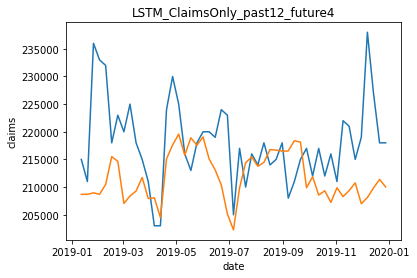

In [13]:
one_week_var=[217548.816026805, 209979.01109298674, 226078.77565453964, 226453.3369389049, 225474.98139809218, 215179.39029309584, 222208.8432315519, 220891.0788523949, 226158.00953748138, 218612.6275377684, 216169.1596149524, 213713.77927978098, 208549.93880512385, 206042.3992845342, 218666.75553618494, 221916.83887125377, 219080.16856606057, 210887.32581102083, 212559.2309864326, 220001.80615847243, 220093.00202529258, 218483.2366760968, 219371.4802352735, 222794.43155903785, 222526.32617248257, 211956.06665495835, 216347.53425449107, 213583.96980225213, 217754.11364113522, 211123.0146722829, 216840.67991645567, 211580.4149609639, 214107.68914307086, 215713.29465543802, 207900.36313971534, 210549.46702717282, 213033.43704313884, 214484.52362501278, 212805.4318999883, 216206.33018689865, 211257.4705013749, 216563.64714173155, 211945.6506408407, 219322.92176147827, 218508.97894220834, 217616.81483320886, 219853.9768261066, 226868.90825450746, 225230.18163297762, 219510.34549880892, 215187.6079927088]
one_month_var=[214335.76065220995, 214611.46188060363, 215932.1607735696, 213097.71480023031, 217388.6133958792, 210951.75273531672, 215878.78360935076, 218396.35838404176, 221668.31673155387, 220685.58198492302, 222481.17355591987, 220692.0239276352, 221289.91466745743, 218578.36049616383,
               216223.42101745546, 214789.41564820975, 210354.25306655312, 205446.92664774111, 209673.22713906012, 214528.37611029166, 217676.0220408729, 215401.85577498484, 215703.10626744633, 217983.9047018948, 218343.41721406626, 217967.5127063437, 218565.52600450732, 220432.0868192589,
               220755.81767511467, 215708.03884505213, 214458.12478188696, 212955.4700028418, 212973.09147515605, 210808.43727594952, 212634.4946715227, 211090.95533865844, 212332.1621786934, 213028.61377994603, 209506.40134020796, 209775.81723339757, 210934.12543799044, 212491.1987795618,
               213465.75255968166, 214347.89086617535, 211598.79448530677, 213169.81325255195, 211907.59587800707, 214963.76384869008, 216117.59994691223, 214999.2023604731, 216661.30776095783]
three_month_var=[208680.76745364798, 208687.58808466655, 208953.7950779212, 208693.64305383104, 210480.14358426706, 215501.33693445582, 214654.49166565447, 207043.29808002568, 208383.54773827217, 209283.84793682306, 211742.5841654003, 207930.3557463542, 208053.5781517238, 204493.77559744328, 215101.49431189444, 217610.02322353798, 219580.11557498042, 215763.70424929346, 218913.2966373325, 217558.63887264454, 219069.56603123143, 215077.07505540166, 213090.05974545676, 210386.64479297612, 205133.84575847688, 202251.72978026082, 209854.1752755563, 214411.3487917422, 215441.07814157073, 213766.32430626062, 214461.84170468172, 216776.877517031, 216682.33351236503, 216491.64450266407, 216523.56196303843, 218389.6949363356, 218125.64736386028, 209879.51174285612, 211878.98540695047, 208553.62561551592, 209328.6020162899, 207229.6003855388, 209877.09832651785, 208267.48842586667, 209366.78195037297, 210757.4483025095, 206983.11448749574, 208108.38585696014, 209842.3748849102, 211384.5769655411, 210020.6174174308]
six_month_var=[207490.22703586263, 207093.10339564213, 203333.44061629035, 203111.79047434626, 201984.40287210266, 199144.82345757776, 198082.80957861705, 198558.0338726183, 199865.4360817007, 202405.29534760638, 201552.55415509504, 201617.5163937052, 204386.6655139452, 203861.48360081104, 204192.71747922956, 203767.35237002792, 205470.02184655, 210258.55065823212, 209383.5897376663, 201694.55874515514, 202435.86187125504, 202573.56556284346, 205297.42876715833, 201303.29772588747, 200882.67722827263, 198560.13125421506, 209855.4511412056, 213384.31939056463, 215531.02381273737, 211864.4189893286, 215002.79593830655, 213839.69341975756, 215160.25335671598, 211191.0744822326, 209509.62607810236, 206218.17898707133, 200970.23908737433, 198471.26625128282, 206401.74333662968, 210936.19066498592, 212301.05219878317, 211756.69662794578, 212881.34312976105, 215076.93439410624, 214369.05669879288, 214093.11211155687, 213982.13759591136, 215398.6491497974, 214753.36664330066, 205911.60203088805, 207879.6931696534]
one_year_var=[220167.9028442518, 217282.51469882423, 216552.54383497548, 213367.37068358774, 209052.30976434718, 206188.87022719203, 208804.50743669577, 206664.42928639124, 207126.80619915097, 204228.09062679636, 210140.77351063536, 210432.90786669604, 211197.94671289652, 200339.09341814916, 199389.44353088638, 197469.45441674002, 202776.67336317798, 207492.41458051608, 205905.31980693416, 204680.77018652958, 203946.05483160747, 205045.91036708976, 203866.01712119541, 206281.7373211618, 205850.88248516407, 199992.91776499653, 202407.1669652791, 199331.26344927427, 200352.19603421647, 195199.4990150476, 195116.53285567602, 194389.45896096271, 190582.68910570015, 190046.67021151257, 191198.40180178458, 192475.72591021625, 195906.81296872062, 194648.3671074498, 193818.3957189224, 197396.55520785972, 196213.364041949, 196690.9197850146, 196043.11860944162, 197582.92043256035, 202334.05383862302, 201381.96848417283, 193476.55012374255, 193612.3457649961, 192897.1265504508, 196203.0814057569, 192012.09237844613]
def mape(actual, pred): 
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

m=mape(original["claims"].tolist(),three_month_var)

def rmse(predictions, targets):
  return np.sqrt(((np.array(predictions)  - np.array(targets)) ** 2).mean())

mse=rmse(original["claims"].tolist(),three_month_var)
print(m, mse)
sns.lineplot(original['date'], original['claims']).set_title("LSTM_ClaimsOnly_past12_future4")
sns_plot =sns.lineplot(df_forecast['date'],three_month_var)

In [20]:
!pip install shap

     |████████████████████████████████| 358kB 7.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491630 sha256=ccfab2ec84ac2169d6bb3b5717541fe1c4134840d5b3f1145361e99023eea163
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [21]:
import shap

In [50]:


explainer = shap.Explainer(model)
# shap_values = explainer(trainX[:-51])
explainer
print(explainer(trainX[:-51]))
# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
# init the JS visualization code
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

TypeError: ignored

In [ ]:
df_forecast.index

RangeIndex(start=0, stop=90, step=1)

In [ ]:
mask = (original["date"] == df_forecast["date"].tolist()[0])
df_forecast["claims"]=df_forecast["claims"]+(original.loc[mask]["claims"].tolist()[0]-df_forecast["claims"].tolist()[0])

IndexError: ignored

In [ ]:
forecast = model.predict(trainX[-n_future:-n_future+1]) #forecast 
forecast

array([[0.06666958]], dtype=float32)

In [ ]:
trainX[-n_future:-n_future+1]


array([[[-0.53194456, -0.53146847,  0.05529954],
        [-0.53195569, -0.5314914 ,  0.03917051],
        [-0.53197217, -0.53154388,  0.0483871 ],
        [-0.53200269, -0.53162701,  0.06682028],
        [-0.53197518, -0.53159595,  0.05990783],
        [-0.5319249 , -0.53137536,  0.02995392],
        [-0.5319249 , -0.53129724,  0.02995392],
        [-0.53188479, -0.53137536,  0.02995392],
        [-0.53188479, -0.53129724,  0.02995392],
        [-0.53189359, -0.53120718,  0.02764977],
        [-0.53188535, -0.53121365,  0.02995392],
        [-0.53186226, -0.5312271 ,  0.05299539],
        [-0.53186299, -0.53123994,  0.03225806],
        [-0.53188848, -0.5312755 ,  0.01382488]]])

In [ ]:
trainY[-n_future:-n_future+1]

array([[0.02764977]])

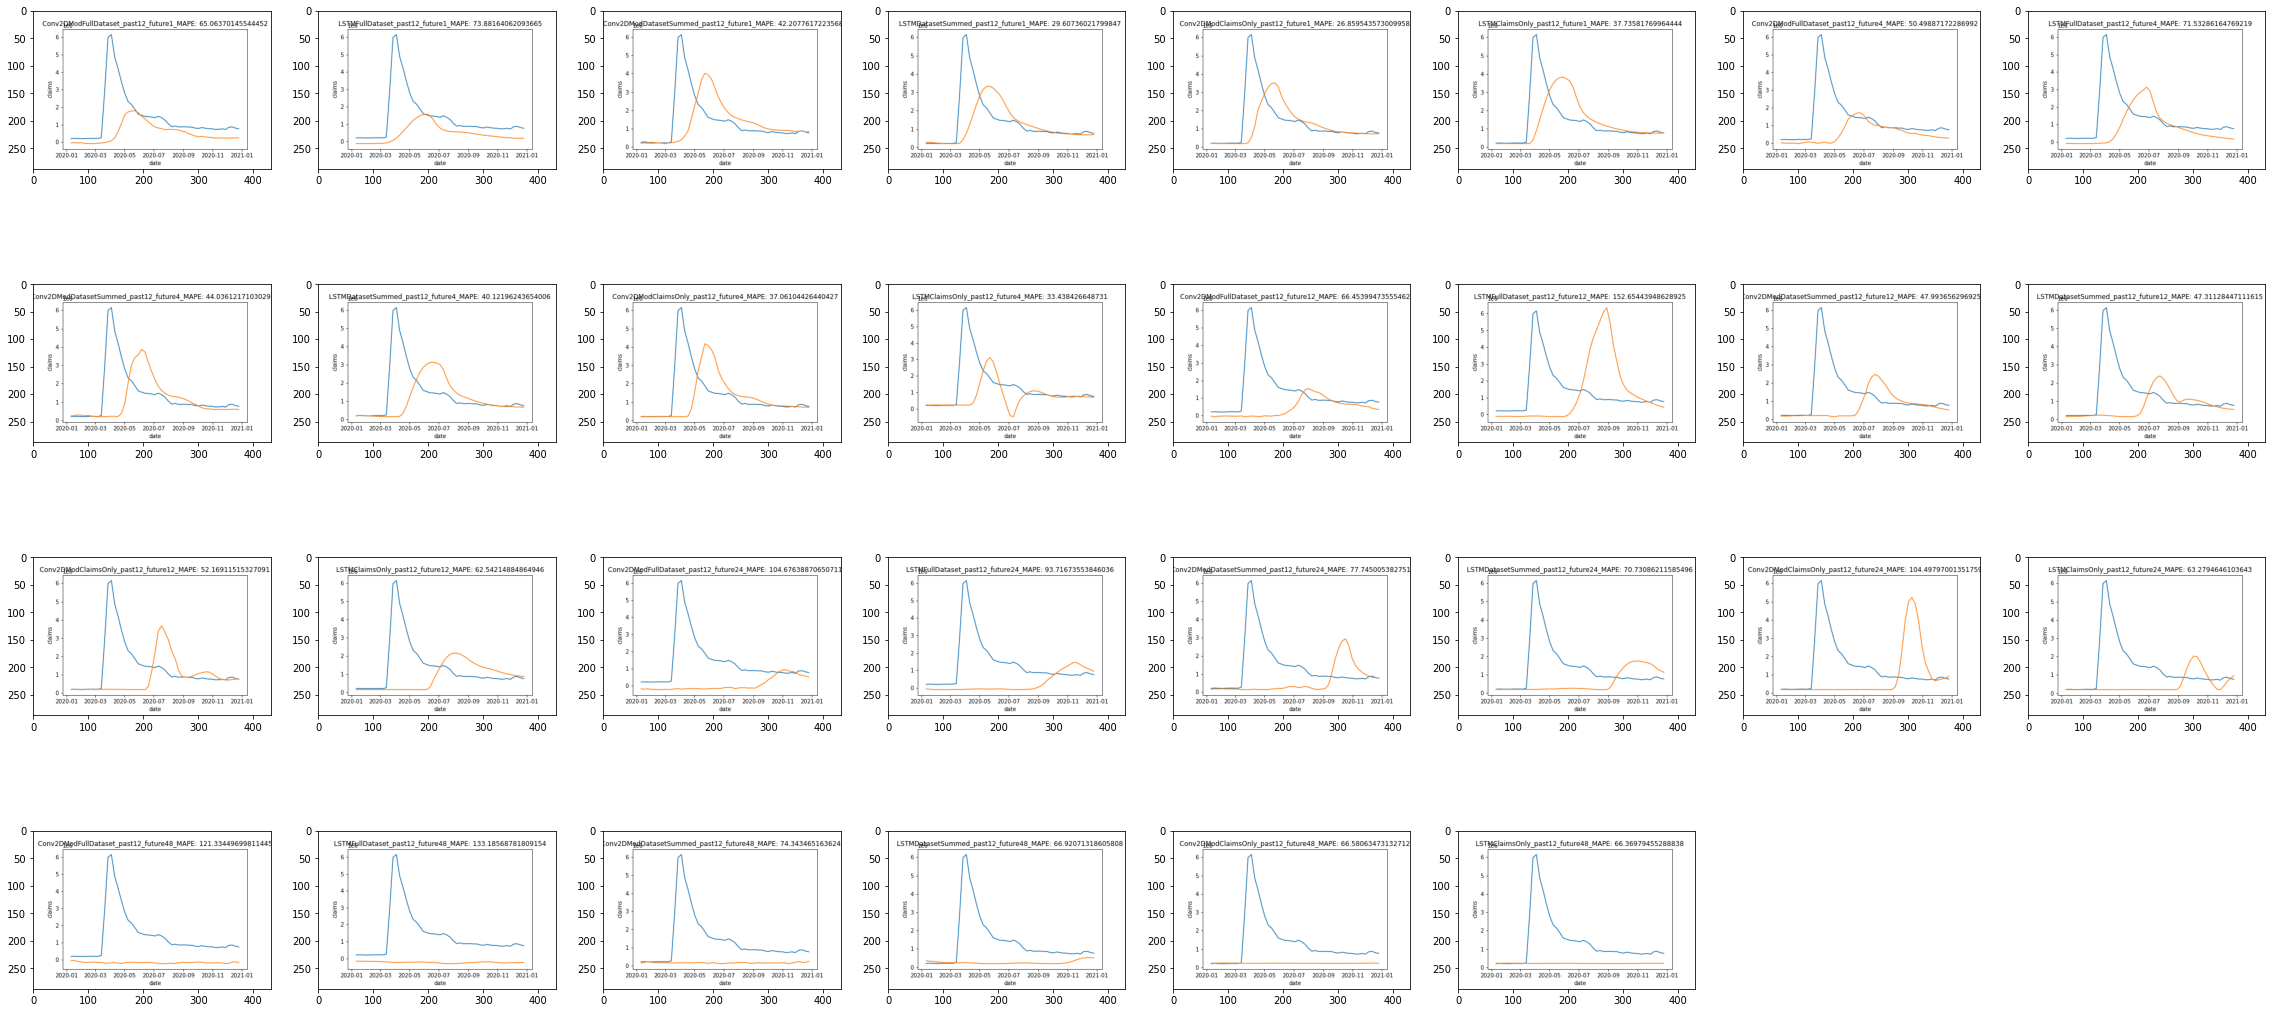

In [ ]:
import os

directory = "./covidforecasts/"
images = os.listdir(directory)

fig = plt.figure(figsize=(40, 150))
columns = 8
rows = np.ceil(len(images))

for x, i in enumerate(images):
    path =  os.path.join("./covidforecasts/",i)
    img = plt.imread(path)
    fig.add_subplot(rows, columns, x+1)
    plt.imshow(img)
plt.show()